In [98]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
import pandas as pd
import shap
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [88]:
# Función para convertir los datos en secuencias de tiempo
def create_sequences(X, y, time_steps=10):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i+time_steps])
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

In [55]:
#Covid transofromar en niveles de restricciones
df = pd.read_csv('../data/DF_modelos/df_industrial_total.csv')
df = df.drop(columns=['Sector_Economic','año','poblacion','velmedia','prec','Empleo','PIB','lectivos'])  

In [56]:
#Analizar los valores de df
df

,consumo,fecha,findesemana,festivos,COVID,tmed
0,995989,2019-01-01,0,1,0,8.590909
1,1702091,2019-01-02,0,0,0,6.617391
2,1826076,2019-01-03,0,0,0,5.604348
3,1806926,2019-01-04,0,0,0,5.004348
4,1341548,2019-01-05,1,0,0,6.173913
...,...,...,...,...,...,...
2003,1403736,2024-06-26,0,0,0,22.623810
2004,1365435,2024-06-27,0,0,0,23.776190
2005,1358576,2024-06-28,0,0,0,24.452381
2006,994740,2024-06-29,1,0,0,20.942857


In [57]:
index_primera_menor_1000 = df[df['consumo'] < 1000].index.min()

# Eliminar todas las filas desde ese índice en adelante
if index_primera_menor_1000 is not None:
    df = df.loc[:index_primera_menor_1000-1]

df

,consumo,fecha,findesemana,festivos,COVID,tmed
0,995989,2019-01-01,0,1,0,8.590909
1,1702091,2019-01-02,0,0,0,6.617391
2,1826076,2019-01-03,0,0,0,5.604348
3,1806926,2019-01-04,0,0,0,5.004348
4,1341548,2019-01-05,1,0,0,6.173913
...,...,...,...,...,...,...
1943,799363,2024-04-27,1,0,0,14.108696
1944,749970,2024-04-28,1,0,0,12.460870
1945,1066271,2024-04-29,0,0,0,11.617391
1946,1076872,2024-04-30,0,0,0,13.543478


In [58]:
#Consumo previo
df['t-1'] = df['consumo'].shift(1)
#df['t-2'] = df['consumo'].shift(2)
#df['t-3'] = df['consumo'].shift(3)
df

C:\Users\minip\AppData\Local\Temp\ipykernel_21032\3808481285.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['t-1'] = df['consumo'].shift(1)


,consumo,fecha,findesemana,festivos,COVID,tmed,t-1
0,995989,2019-01-01,0,1,0,8.590909,NaN
1,1702091,2019-01-02,0,0,0,6.617391,995989.0
2,1826076,2019-01-03,0,0,0,5.604348,1702091.0
3,1806926,2019-01-04,0,0,0,5.004348,1826076.0
4,1341548,2019-01-05,1,0,0,6.173913,1806926.0
...,...,...,...,...,...,...,...
1943,799363,2024-04-27,1,0,0,14.108696,1076123.0
1944,749970,2024-04-28,1,0,0,12.460870,799363.0
1945,1066271,2024-04-29,0,0,0,11.617391,749970.0
1946,1076872,2024-04-30,0,0,0,13.543478,1066271.0


In [59]:
df.dropna(inplace=True)
df = df.reset_index(drop=True)
df

C:\Users\minip\AppData\Local\Temp\ipykernel_21032\3017248869.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


,consumo,fecha,findesemana,festivos,COVID,tmed,t-1
0,1702091,2019-01-02,0,0,0,6.617391,995989.0
1,1826076,2019-01-03,0,0,0,5.604348,1702091.0
2,1806926,2019-01-04,0,0,0,5.004348,1826076.0
3,1341548,2019-01-05,1,0,0,6.173913,1806926.0
4,1201714,2019-01-06,1,0,0,9.130435,1341548.0
...,...,...,...,...,...,...,...
1942,799363,2024-04-27,1,0,0,14.108696,1076123.0
1943,749970,2024-04-28,1,0,0,12.460870,799363.0
1944,1066271,2024-04-29,0,0,0,11.617391,749970.0
1945,1076872,2024-04-30,0,0,0,13.543478,1066271.0


In [60]:
#Formatear 
df['COVID'].replace(2,3,inplace=True)


C:\Users\minip\AppData\Local\Temp\ipykernel_21032\1001056524.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['COVID'].replace(2,3,inplace=True)


In [61]:
df['COVID'].replace(1,2,inplace=True)

C:\Users\minip\AppData\Local\Temp\ipykernel_21032\2916957206.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['COVID'].replace(1,2,inplace=True)


In [62]:
df['COVID'].replace(3,1,inplace=True)

C:\Users\minip\AppData\Local\Temp\ipykernel_21032\1387649947.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['COVID'].replace(3,1,inplace=True)


## Paso 1: Preparación de los datos.

In [63]:
df.dtypes

consumo          int64
fecha           object
findesemana      int64
festivos         int64
COVID            int64
tmed           float64
t-1            float64
dtype: object

In [64]:
df.nunique()

consumo        1915
fecha          1947
findesemana       2
festivos          2
COVID             3
tmed           1847
t-1            1915
dtype: int64

In [65]:
df.shape

(1947, 7)

### *Transformación variable `Fecha`*

1. Convertir fechas a formato numérico (timestamp)

In [67]:

# Asegúrate de que la columna de fecha está en formato datetime
df['fecha'] = pd.to_datetime(df['fecha'], format='%Y')  # Ajusta el formato según tus datos

# Convertir la columna de fecha a timestamp
df['fecha'] = df['fecha'].astype(np.int64) // 10**9  # Convertir a dias


In [68]:
df['fecha'].tail

<bound method NDFrame.tail of 0       1546387200
1       1546473600
2       1546560000
3       1546646400
4       1546732800
           ...    
1942    1714176000
1943    1714262400
1944    1714348800
1945    1714435200
1946    1714521600
Name: fecha, Length: 1947, dtype: int64>

In [69]:
df

,consumo,fecha,findesemana,festivos,COVID,tmed,t-1
0,1702091,1546387200,0,0,0,6.617391,995989.0
1,1826076,1546473600,0,0,0,5.604348,1702091.0
2,1806926,1546560000,0,0,0,5.004348,1826076.0
3,1341548,1546646400,1,0,0,6.173913,1806926.0
4,1201714,1546732800,1,0,0,9.130435,1341548.0
...,...,...,...,...,...,...,...
1942,799363,1714176000,1,0,0,14.108696,1076123.0
1943,749970,1714262400,1,0,0,12.460870,799363.0
1944,1066271,1714348800,0,0,0,11.617391,749970.0
1945,1076872,1714435200,0,0,0,13.543478,1066271.0


# 1. Preparar los datos

In [81]:
#Ordenar los datos cronologicamnte
df = df.sort_values(by='fecha')

1.1. Dividir los datos en características y objetivo, en X e Y

In [82]:
# Definir características (X) y objetivo (y)
X = df.drop(columns=['consumo','fecha'])  
y = df['consumo']  



In [83]:
# Escalar los datos con MinMaxScaler (LSTM es sensible a la escala de los datos)
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

In [84]:
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

In [85]:
# Dividir en conjunto de entrenamiento y prueba (manteniendo el orden temporal)
train_size = int(len(X) * 0.9)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

In [86]:
X_train

array([[0.        , 0.        , 0.        , 0.17305586, 0.17568884],
       [0.        , 0.        , 0.        , 0.13898399, 0.40067953],
       [0.        , 0.        , 0.        , 0.11880408, 0.44018582],
       ...,
       [0.        , 0.        , 0.        , 0.57753139, 0.21425069],
       [0.        , 0.        , 0.        , 0.65459524, 0.24578116],
       [0.        , 0.        , 0.        , 0.57799097, 0.24978739]])

In [87]:
X_test

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.09680107e-01,
        2.14303581e-01],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.32908722e-01,
        1.75231912e-01],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.13459971e-01,
        7.41989210e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.86743955e-01,
        4.71433975e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.88184119e-01,
        1.72706709e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.13774581e-01,
        1.67843661e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.92739434e-01,
        1.55161245e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.94910755e-01,
        1.73820666e-01],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.94033368e-01,
        1.63713480e-01],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.02953472e-01,
        7.36935617e-02],
       [0.00000000e+00, 0.0000

In [89]:
# Crear secuencias de tiempo para LSTM
time_steps = 10  # Esto significa que la predicción se basará en los últimos 10 días
X_train_seq, y_train_seq = create_sequences(X_train, y_train, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, time_steps)
print(f"Forma de X_train_seq: {X_train_seq.shape}")  # Debe ser (samples, time_steps, features)

Forma de X_train_seq: (1742, 10, 5)


# 2. Definir el modelo LSTM

In [91]:
# Definir el modelo LSTM
model = Sequential()

In [92]:
# Primera capa LSTM con 50 unidades y dropout para regularización
model.add(LSTM(50, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(Dropout(0.2))
# Segunda capa LSTM
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
# Capa de salida para la predicción continua de la demanda de electricidad
model.add(Dense(1))

C:\Users\minip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [93]:
# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

In [94]:
# Mostrar el resumen del modelo
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 50)         │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,451 (122.86 KB)

 Trainable params: 31,451 (122.86 KB)

 Non-trainable params: 0 (0.00 B)

# 3. Entrenar el modelo

In [95]:
history = model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=32, validation_data=(X_test_seq, y_test_seq))

Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0446 - val_loss: 0.0126
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0140 - val_loss: 0.0117
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0136 - val_loss: 0.0046
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0117 - val_loss: 0.0055
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0085 - val_loss: 0.0046
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0078 - val_loss: 0.0082
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0087 - val_loss: 0.0030
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0087 - val_loss: 0.0026
Epoch 9/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0083 - val_loss: 0.0041
Epoch 10/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0083 - val_loss: 0.0061
Epoch 11/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0078 - val_loss: 0.0032
Epoch 12/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.

# Evaluar el modelo

In [96]:
# Evaluar el modelo en el conjunto de prueba
loss = model.evaluate(X_test_seq, y_test_seq)
print(f'Loss: {loss}')

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015     
Loss: 0.0016653869533911347


In [97]:
#Comprobar la prediccion
# Predecir los valores de prueba
y_pred_scaled = model.predict(X_test_seq)
# Desescalar las predicciones y los valores reales para comparar
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_true = scaler_y.inverse_transform(y_test_seq)
# Comparar las primeras predicciones con los valores reales
print(f"Predicciones: {y_pred[:5].flatten()}")
print(f"Valores reales: {y_test_true[:5].flatten()}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
Predicciones: [859187.7  841065.3  835481.3  852855.9  768518.06]
Valores reales: [876720. 958533. 649894. 956640. 987631.]


## Comprobacion de caracteristicas generales

In [73]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [74]:
# Definir el modelo XGBoost
model_xgb = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=100, learning_rate=0.1)

# Entrenar el modelo con los datos de entrenamiento
model_xgb.fit(X_train_scaled, y_train)

# Realizar predicciones con los datos de prueba
y_pred = model_xgb.predict(X_test_scaled)

# Calcular el error cuadrático medio (RMSE) como métrica de evaluación
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE: {rmse}')

# Obtener la importancia de las características
importancia = model_xgb.feature_importances_

# Crear un DataFrame para visualizar las importancias
feature_importance = pd.DataFrame({'Variable': X.columns, 'Importancia': importancia*100})
feature_importance = feature_importance.sort_values(by='Importancia', ascending=False)
# Mostrar las variables ordenadas por importancia
print(feature_importance)

RMSE: 104769.0501597512
      Variable  Importancia
1  findesemana    37.844616
5          t-1    36.166225
2     festivos    10.263535
3        COVID     8.327732
0        fecha     5.259157
4         tmed     2.138731


C:\Users\minip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [23]:
# Crear un modelo de SHAP para un modelo de red neuronal o cualquier otro modelo
explainer = shap.KernelExplainer(model_xgb.predict, X_train_scaled)
shap_values = explainer.shap_values(X_test_scaled)

# Visualizar la importancia de las características
shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns)

Using 1769 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  1%|          | 1/176 [00:02<06:53,  2.37s/it]


KeyboardInterrupt: 

In [75]:
df_X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
df_X_train_selected = df_X_train_scaled[['findesemana', 't-1', 'festivos', 'COVID', 'tmed', 'fecha']]
df_X_train_selected

,findesemana,t-1,festivos,COVID,tmed,fecha
0,-0.632456,-1.337818,-0.196748,-0.629797,-1.391208,-1.731073
1,-0.632456,0.193103,-0.196748,-0.629797,-1.545792,-1.729117
2,-0.632456,0.461918,-0.196748,-0.629797,-1.637348,-1.727161
3,1.581139,0.420398,-0.196748,-0.629797,-1.458879,-1.725205
4,1.581139,-0.588602,-0.196748,-0.629797,-1.007733,-1.723249
...,...,...,...,...,...,...
1766,-0.632456,-1.423132,-0.196748,-0.629797,-0.601038,1.723249
1767,1.581139,-1.355940,-0.196748,-0.629797,-0.363522,1.725205
1768,1.581139,-1.929540,-0.196748,-0.629797,-0.266659,1.727161
1769,-0.632456,-2.105375,-0.196748,-0.629797,-0.523414,1.729117


In [76]:
#Test VIF
vif = pd.Series([variance_inflation_factor(df_X_train_selected.corr().values, i) for i in range(df_X_train_selected.corr().shape[1])], index=df_X_train_selected.columns)
vif

findesemana    1.111830
t-1            2.913607
festivos       1.079916
COVID          1.797220
tmed           1.284506
fecha          3.385639
dtype: float64

In [25]:
X_train_scaled

array([[-1.73107197, -0.63295609, -0.19686325, ..., -1.64008835,
         0.46124858, -1.34162526],
       [-1.72911374,  1.57988842, -0.19686325, ..., -1.46150248,
         0.41973091,  0.1913208 ],
       [-1.72715552,  1.57988842, -0.19686325, ..., -1.01005865,
        -0.58922   ,  0.46049199],
       ...,
       [ 1.72715552,  1.57988842, -0.19686325, ..., -0.26849578,
        -1.9300933 , -1.42705186],
       [ 1.72911374, -0.63295609, -0.19686325, ..., -0.52542043,
        -2.10592009, -1.35977046],
       [ 1.73107197, -0.63295609, -0.19686325, ..., -0.88723938,
        -1.49417945, -1.9341297 ]])

In [78]:
print(df_X_train_selected.isnull().sum())

findesemana    0
t-1            0
festivos       0
COVID          0
tmed           0
fecha          0
dtype: int64


In [79]:
df_X_train_selected

,findesemana,t-1,festivos,COVID,tmed,fecha
0,-0.632456,-1.337818,-0.196748,-0.629797,-1.391208,-1.731073
1,-0.632456,0.193103,-0.196748,-0.629797,-1.545792,-1.729117
2,-0.632456,0.461918,-0.196748,-0.629797,-1.637348,-1.727161
3,1.581139,0.420398,-0.196748,-0.629797,-1.458879,-1.725205
4,1.581139,-0.588602,-0.196748,-0.629797,-1.007733,-1.723249
...,...,...,...,...,...,...
1766,-0.632456,-1.423132,-0.196748,-0.629797,-0.601038,1.723249
1767,1.581139,-1.355940,-0.196748,-0.629797,-0.363522,1.725205
1768,1.581139,-1.929540,-0.196748,-0.629797,-0.266659,1.727161
1769,-0.632456,-2.105375,-0.196748,-0.629797,-0.523414,1.729117


1. Visualizar la pérdida durante el entrenamiento

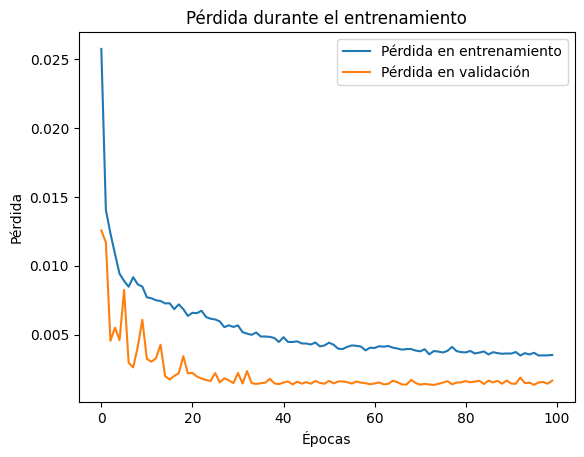

In [99]:
# Visualizar la pérdida durante el entrenamiento
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# Guardar modelo

In [102]:
#Extraccion del modelo a una crapeta
# Guardar el modelo entrenado en una carpeta
model.save('../models/modelo_industrial.h5')


In [55]:
# Lista de festivos a modificar
lista_festivos = pd.to_datetime(['2024-01-01', '2024-12-25'])

def generar_caracteristicas_fecha(fecha_str):
    ano=fecha_str[0:4]
    fecha = pd.to_datetime(fecha_str)
    dia_semana = fecha.weekday()

    # Determinar si es fin de semana
    findesemana = 1 if dia_semana >= 5 else 0

    # Determinar si es festivo
    festivos = 1 if fecha in lista_festivos else 0

    # Determinar si es lectivo
    lectivos = 1 if dia_semana < 5 and not festivos else 0

    # Convertir la fecha a segundos desde la época
    fecha_seg = fecha.value // 10**9 

    # Otros valores generados por nosotros
    COVID = 0  
    tmed = 15  # Valor de ejemplo
    prec = 0.1  # Valor de ejemplo
    velmedia = 2.0  # Valor de ejemplo

    # Diccionario a devolver
    return {
        'tendencia':2009,
        'fecha': fecha_seg,
        'findesemana': findesemana,
        'festivos': festivos,
        'lectivos': lectivos,
        'COVID': COVID,
        'tmed': tmed,
    }

In [56]:
fecha_a_predecir='2024-07-01'
#  Generar características con la función creada
caracteristicas = generar_caracteristicas_fecha(fecha_a_predecir)

df_pred = pd.DataFrame([caracteristicas])

# Solo escalamos las columnas numéricas (como en el entrenamiento)
df_pred_num = df_pred[['tmed', 'prec', 'velmedia', 'poblacion', 'PIB']]
df_pred_num_normalizado = scaler.transform(df_pred_num)

# Añadir las columnas no numéricas sin escalar
df_pred_final = df_pred.copy()
df_pred_final[['tmed', 'prec', 'velmedia', 'poblacion', 'PIB']] = df_pred_num_normalizado

# Realizar la predicción del modelo con los datos proporcionados
prediccion_consumo = modelInd.predict(df_pred_final)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [57]:
print(prediccion_consumo)

[[-0.01211098]]


## Paso 4: Optimización del modelo

Aquí hay algunas estrategias que puedes utilizar para optimizar tu modelo:

#### 1. **Ajuste de Hiperparámetros**

- **Número de Neuronas y Capas**: Experimenta con el número de neuronas en cada capa y la cantidad de capas ocultas. Un modelo más complejo puede capturar mejor patrones en los datos, pero ten cuidado con el sobreajuste.

- **Tasa de Aprendizaje (Learning Rate)**: Ajusta la tasa de aprendizaje del optimizador. Puedes utilizar un optimizador como Adam que permite cambiar dinámicamente la tasa de aprendizaje.


### 2. **Regularización**

- **Dropout**: Introduce capas de `Dropout` para evitar el sobreajuste. Esto apaga aleatoriamente un porcentaje de neuronas durante el entrenamiento, lo que ayuda a que el modelo generalice mejor
- **Regularización L1 o L2**: Aplica técnicas de regularización a las capas densas.


#### 3. **Aumentar el número de épocas**

Aumentar el número de épocas puede ayudar a que el modelo aprenda mejor, pero asegúrate de monitorear la pérdida en el conjunto de validación para evitar el sobreajuste.


#### 4. **Early Stopping**

Implementa `EarlyStopping` para detener el entrenamiento si la pérdida en el conjunto de validación no mejora después de un número específico de épocas. Esto ayuda a evitar el sobreajuste.


#### 5. **Prueba con diferentes optimizadores**

Prueba diferentes optimizadores (como SGD, Adam, RMSprop) para ver si alguno mejora el rendimiento.


### 6. **Evaluar mejoras**

Después de aplicar algunas de estas técnicas, vuelve a evaluar el modelo utilizando el conjunto de prueba y compara el nuevo `Test Loss` y el `RMSE` con los resultados anteriores.
